### Code Challenge
 
 *This notebook contains both Part1 and Part2*
 
 *prompt:* https://gist.github.com/jeff-boykin/ec951ccaa1f90470b6ccc2bb1315d28a
 
 *author:* William Sutton wsutton17@gmail.com
 
 *written and submitted:* March 18 2020 
 
 *at request of:* Malorie O'Toole

# Part 1

In [185]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

### Load and Transform Data

The dataset needs to be loaded with `header=None` to prevent pandas from interpreting the first row as the column names. The actual column names are loaded from a text file and attached to the dataframe.

The dataset is medium sized (about 500 rows, 30 columns), and fortunately for us contains no null values. If it did contain null values we would need to either: drop the rows or columns containing any nulls, or impute the values for null values based on the other data.

All the `X` fields values are numeric. We verify this by checking the dtype of each column.

The `diagnosis` filed (y value) is a string type containg both `B` and `M` for Benign and Malignant. Ultimately we'll want to transform this to 1 and 0 for a a binary classification. But for now, these letter label are more descriptive and helpful for EDA.

One further step could be considered at this point: Scaling the X fileds to contain the same mean variance. This is important as a pre-processing steps for some model algortihms, but can also reduce the interpretability of EDA. For this reason we'll not pursue this step until we model.

In [115]:
with open('field_names.txt', 'r') as f:
    field_names = f.readlines()
    
field_names = [elem.strip() for elem in field_names]

df = pd.read_csv('breast-cancer.csv', header=None, names=field_names)

print(f'Data Shape: {df.shape}')

df.head(3)

Data Shape: (569, 32)


,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [116]:
# check for nulls / na's
df.isnull().sum().sum()

0

In [117]:
# check for string fields that may need 
# to be OneHotEncoded / dummified
tmp = [(col_name, col_type) 
       for col_name, col_type in zip(list(df.columns), list(df.dtypes)) 
       if col_type == np.dtype('O')
      ]
tmp

[('diagnosis', dtype('O'))]

In [118]:
# Only the y-value, diagnosis needs to be transformed, view the 
# class labels here
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [119]:
# demonstration of transforming y to 1/0, not applied to df 
# untill after EDA
transform_dict = {'B':0, 'M': 1}
transfrom_diagnosis = df['diagnosis'].map(lambda x: transform_dict[x])
transfrom_diagnosis[:3]

0    1
1    1
2    1
Name: diagnosis, dtype: int64

##### Compare mean for `smoothness` and `compactness` b/w malignant and benign

We'll do it manually, at first using numpy methods, then we'll use pandas groupby / agg to do get the same result.

In [120]:
malig_smooth = df[(df['diagnosis'] == 'M')]['smoothness_mean']
benin_smooth = df[(df['diagnosis'] == 'B')]['smoothness_mean']

mean_malig_smooth = np.mean(malig_smooth)
mean_benin_smooth = np.mean(benin_smooth)

tmp_df = {'diagnosis': ['malignant', 'benign'],
          'smoothness mean': [mean_malig_smooth, mean_benin_smooth]}

pd.DataFrame(tmp_df).round(2)

,diagnosis,smoothness mean
0,malignant,4.32
1,benign,2.00


In [121]:
median_malig_smooth = np.median(malig_smooth)
median_benin_smooth = np.median(benin_smooth)

median_malig_smooth, median_benin_smooth

tmp_df = {'diagnosis': ['malignant', 'benign'],
          'smoothness median': [median_malig_smooth, median_benin_smooth]}

pd.DataFrame(tmp_df).round(2)

,diagnosis,smoothness median
0,malignant,3.68
1,benign,1.85


In [122]:
df.groupby(['diagnosis']).agg(['median', 'mean'])['smoothness_mean']

,median,mean
diagnosis,,
B,1.8510,2.000321
M,3.6795,4.323929


##### Do they differ?

Below we'll use both graphical and statistical methods to compare if tumor smoothness is statistically significant across diagnosis classes.

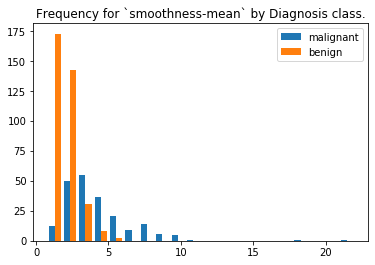

In [123]:
label = ['malignant', 'benign']
_ = plt.hist([malig_smooth, benin_smooth], bins=20)
_ = plt.legend(label)
_ = plt.title('Frequency for `smoothness-mean` by Diagnosis class.')


In [124]:
sd_smooth = np.std(malig_smooth)

z = ( (mean_malig_smooth - mean_benin_smooth) 
       / 
      (sd_smooth / np.sqrt(len(malig_smooth)))
     )

msg = "Comparing the mean smoothness of M vs B \nZ-score: "
print(msg + str(round(z,2)))

Comparing the mean smoothness of M vs B 
Z-score: 13.2


The `Benign-Smoothness` mean differs from the `Malignant-Smoothness` with Z-Score of 13+, meaning p-value far below 1e-3, meaning it is quite statistically significant that the two samples come from different distributions.

We can also see the difference in the right tail between the two distributions graphically: Malignant has much fatter tail.

These look like log-normal distirbutions, let's apply a log-transform to the Smoothness variable and see a close to normal distribution:

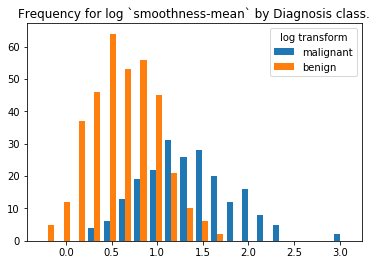

In [125]:
log_malig_smooth = np.log(malig_smooth)
log_benin_smooth = np.log(benin_smooth)

label = ['malignant', 'benign']
_ = plt.hist([log_malig_smooth, log_benin_smooth], bins=20)
_ = plt.legend(label, title='log transform')
_ = plt.title('Frequency for log `smoothness-mean` by Diagnosis class.')

##### Build a function to pull bootstrap samples from the data.
The key is to allow to perfrom sampling with replacement, we do this by pulling a random number that covers the entire length of the index of rows of the dataset, for each random pull.

In [126]:
def bootstrap(data,
              pct_sampled=0.1, 
              num_samples=None, 
              seed=None):
    '''
        return: an index on `data` (list of int's) for a bootstrap sample
        input:
          data -        (pd.DataFrame)
          pct_sampled - (float or None) return pct
          num_samples - (int or None)   return len num_samples
          seed -        (int or None)   seed that int before rand operation
    '''
    
    assert pct_sampled is not None or num_samples is not None, \
           'must have a value for pct_sampled or num_samples '
    
    if seed is not None and isinstance(seed, int):
        np.random.seed(seed)
        
    n = len(data)
    
    ret_obs = ( int(pct_sampled * n) 
                if pct_sampled is not None else
                num_samples
              )
    
    return [np.random.randint(low=0, high=n-1) 
            for _ in range(ret_obs)
           ]
    

In [127]:

# Let's build some test cases to see how this function works

sample1 = bootstrap(df, pct_sampled=0.1, seed=0)

sample2 = bootstrap(df, pct_sampled=0.2)

sample3 = bootstrap(df, pct_sampled=None, num_samples=200)

print('indexes             |  sample size')
print( *[(str(e[:3]) + '...', len(e)) for e in [sample1, sample2, sample3]]
       ,sep='\n')

indexes             |  sample size
('[559, 192, 359]...', 56)
('[47, 131, 180]...', 113)
('[73, 297, 394]...', 200)


In [128]:
# using sample1 generated from bootstrap,
# we'll pull a subest of the dataframe, df
# called sample1_data below

sample1_ind = pd.Series([e in sample1 for e in df.index.tolist()])
sample1_data = df[sample1_ind]
sample1_data.head()

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.2396,0.2273,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750
28,852973,M,15.30,25.27,102.40,732.4,0.10820,0.1697,0.1683,0.08751,...,20.27,36.71,149.30,1269.0,0.1641,0.6110,0.6335,0.2024,0.4027,0.09876
42,855625,M,19.07,24.81,128.30,1104.0,0.09081,0.2190,0.2107,0.09961,...,24.09,33.17,177.40,1651.0,0.1247,0.7444,0.7242,0.2493,0.4670,0.10380
53,857392,M,18.22,18.70,120.30,1033.0,0.11480,0.1485,0.1772,0.10600,...,20.60,24.13,135.10,1321.0,0.1280,0.2297,0.2623,0.1325,0.3021,0.07987
57,857793,M,14.71,21.59,95.55,656.9,0.11370,0.1365,0.1293,0.08123,...,17.87,30.70,115.70,985.5,0.1368,0.4290,0.3587,0.1834,0.3698,0.10940


### Exploratory Analysis

Identifying 3 variables that are predictive of a malignant tumor.

We'll use the histogram method for our graphical display, and we'll use pearson's correlation coefficient (display in plot title as `rho`) as a metric to assess the predictive impact of the filed on diagnosis.

We'll use a re-usable function to save time and apply consitent measures to each of our fields of interest.


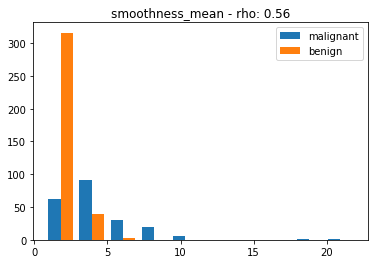

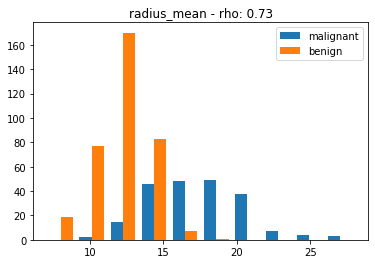

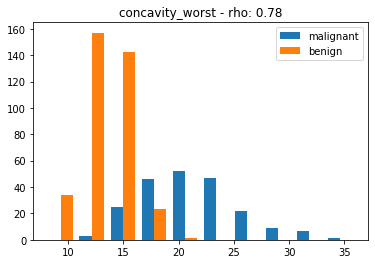

In [129]:
def plot_field(field_name):
    
    malig_x = df[(df['diagnosis'] == 'M')][field_name]
    benin_x = df[(df['diagnosis'] == 'B')][field_name]
    
    corr = np.corrcoef(df[field_name], transfrom_diagnosis)
    corr = round(corr[0][1], 2)

    _ = plt.hist([malig_x, benin_x])
    _= plt.legend(['malignant', 'benign'])
    _ = plt.title(field_name + " - rho: " + str(corr))
    plt.show()
    
plot_field('smoothness_mean')
plot_field('radius_mean')
plot_field('concavity_worst')

Each of the three fields has a correlation coefficient larger than 0.5 and the histograms show strong separation of the mode and in the tails.

In `radius_mean` and `concavity_worst`, there are regions in the tails where these variables are perfect predictors of diagnosis: 
 - there are no malignant cases with radius < 10 and no benign cases with radius > 20. 
 - But a large portion of the data is distributed in the middle, e.g. 12 to 17 for radius_mean, where radius can not predict diagnosis by itself. 
 
It looks like the naive view of "Very Big is Very Bad" is a subset of the dataset, for the rest we'll need multi-variable tools.

----

### Modelling

Below we'll implement RandomForest and LogisticRegression on the preprocessed dataset. 

To control for overfitting we'll set in upper limit on max_depth and use L2 penalty ("ridge"), respectively to control for overfitting.



##### Pre-Processing
Before modelling this binary classification task, we'll apply some pre-processing steps:
 - transforming the y-value, diagnosis into numeric 1/0
 - drop uneccesary columns like 'ID'
 - applying a train test split
 

In [130]:
transform_dict = {'B':0, 'M': 1}
y = df['diagnosis'].map(lambda x: transform_dict[x])

In [133]:
x_fields = [col for col in df.columns 
            if col not in ('ID', 'diagnosis')]

X = df[x_fields]

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [137]:
X_train.shape, X_test.shape

((426, 30), (143, 30))

##### Fitting
Below we instatiate our models along witht the hyperparameters we'll use to fit them. These values are determined through a combination of experimentation with this dataset and experience with other datasets.

Note: `max_depth` and `penalty` and `C` for their use in controlling over-fitting.

In [167]:
lr = LogisticRegression(penalty = 'l2', C=2.0, 
                        solver='newton-cg', max_iter=200)

rf = RandomForestClassifier(max_depth=5, n_estimators = 100)

In [168]:
lr.fit(X_train, y_train);
rf.fit(X_train, y_train);

##### Model Evaluation
Below we evaluate both models on two classiciation metrics:
    - accuracy (for both train and test datasets)
    - roc-auc "area under the curve" (only for test set)
    
We find both models perform well, with the RandomForest having lower bias, and the LogisticRegression having lower variance.

In [186]:
lr_train = lr.score(X_train, y_train)
lr_test =  lr.score(X_test, y_test)

rf_train = rf.score(X_train, y_train)
rf_test =  rf.score(X_test, y_test)

lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

In [189]:
tmp = {
    'model': [
        'Logistic Regression (L2)', 
        'Random Forest (max_depth=5)'
        ],
    'accuracy (train)': [lr_train, rf_train],
    'accuracy (test)':  [lr_test, rf_test],
    'roc-auc (test)':   [lr_auc, rf_auc],
}

pd.DataFrame(tmp).round(4)

,model,accuracy (train),accuracy (test),roc-auc (test)
0,Logistic Regression (L2),0.9648,0.958,0.9886
1,Random Forest (max_depth=5),0.9977,0.951,0.9959


##### Variable Importance

We'll look at the top 7 most predictive features in each of the two models. We'll use a reusable function to do this.

In logistic regression we can use the absolute value of the coefficients to assess the importance of the feature to the model, while with random forests we must use a builtin feature_importance metric which accumulates the number of times a feature is used as a split within an tree esitmator of the forest.

In [221]:
def feat_magnitude(feats):
    ''' 
        return a dataframe with:
            index as feature-names 
            a column, `feat` sorted DESC by absolute value
            
        good for comparing features from rf's and lr's
    '''
    tmp = pd.DataFrame(feats, columns=x_fields, index=['feat']).T
    tmp['feat_abs'] = tmp['feat'].map(lambda x: abs(x))
    tmp = (tmp.sort_values(by='feat_abs', ascending=False)[['feat']])
    return tmp.copy()

In [215]:
# use the variable 
lr_coefs = lr.coef_

# for sorting /display 
feat_magnitude(lr_coefs).head(7)

,feat
area_worst,-2.053862
symmetry_worst,1.710698
fractal_dimension_mean,0.748429
radius_mean,-0.645300
perimeter_mean,0.641250
concave_points_mean,0.556741
symmetry_mean,0.518185


In [220]:
rf_feats = rf.feature_importances_

feat_magnitude([rf_feats]).head(7)

,feat
concave_points_sd_error,0.165197
fractal_dimension_mean,0.138409
concave_points_worst,0.124604
concavity_worst,0.103517
radius_mean,0.065197
radius_worst,0.058231
perimeter_sd_error,0.057551


**Further highly technichal notes on interpreting feature importance:** Many of these features appear to be correlated ("multi-collinearity") and this will be difficult for logistic regression to deal with, even with using an L2-regularization. It will also mean that different basis function or even different solvers could find drastically different variable importance ("Rashomon conclusions" Breiman 2001) for roughly equal model importance.

Random Forest seem to identify multiple metrics on concavity as of the highest importantance, while logistic regression does not.

We see that `radius_mean`, and `fractal_dimension_mean` are variables shared across different Learners (RF vs LR) as in top7 impact.

## Technichal Interpretation
These models should be thought of as naive baselines for further modelling. We see a baseline of 96-99% accuracy on training set (which can be cranked to 100% if desired) and 95% on the test set. 

Two steps to pursue before even bringing in more advanced modelling techniques: 1.) normalize the dataset, and perhaps apply some log transforms to some features to make them distributed more normally. 2.) build more cross validation samples to view how the model fits/tests under different dataset-splits.

## Non-Technichal Interpretation
We used two techniques to identify the factors that predict malignant vs benign tumors using two dozen statistics calculated on images of the cells/tumor.

Each of these techniques has roughly 95% accurracy, meaning they will usually predict correctly 19 out 20 times.

When exploring the factors individually, like tumor radius, we see a sample at each extreme of the distribution is highly predictive, while there is not a good predictive separation in the middle of the distribtuion. For example if all observations have a radius 1-20, and observation with radius 1-3 are very likely benign, and observation with radius 17-20 are very likely malignant. But for a radius of 8-12, we would need more information.

So, the real challenge is this situation is not separating the clearly malignant from the clearly benign, but trying to separate the two when the situations is ambiguous on some factors.


# Part 2

### Student1

##### code

 (-) Loading the dataset as `d` is too ambiguous a variable name, and doesn't match your code further along the script. Did you forget a transform step where d -> data? Even then, use: `data_raw -> data` as variable names
 
 (-) No need to import `cross_val_score` twice in your file.
 
 (-) All imports at the top of the file; instead of scattered thorughout.
 
 (+) Nice use of commenting to explain is happening at each step in the model pipeline!
 
 (-) Several of the imports don't work as written, e.g. use `from sklearn.linear_model import LinearRegression`
 
 (-) need to change the metric: `mean_absolute_error -> neg_mean_absolute_error` 

-----
 
##### methodology

 - you're variables aren't x1 and x2 but y and x1. The way you have it technichally works, but you want your variables to correspond to the names 
 
 
 - you'll need to change `cv` argument to be > 1 in your `cross_val_score` function. The idea of cross_val_score is we want to try a train/test split multiple times to see how different random splits impact our model performance.
 
 
 - nice use of get_dummies to create a predictor variable from categorical.
----- 
##### conceptual:

 - Although there were problems with some or most of these lines and concepts, you produced an end-to-end model which is an excellent start. This can form a strong foundation for refining each of the subconcepts, one at a time. As you increase your knowledge in one area, add that improvement to this file, and watch your model's score go up!
 
-----


### Student2

##### code
 
 (+) Nice use of commenting to explain is happening at each step in the model pipeline!
 
 (-) One of the imports don't work as written, e.g. use `from sklearn.model_selection import cross_val_score`
 
 (-) need to change the scoring metric: `mean_absolute_error -> neg_mean_absolute_error` 

 (+/-) I'd do data[['ContractType']] which will allow you to add more X-variables to your model
  
-----
 
##### methodology

 - I'd check for null values before proceeding to fit your model, otherwise, that step may fail.
 
 - Print out all your cross-val scores, that way you see min and max scores and the range.
----- 
##### conceptual:

 - You've got the basic down, now time to move into intermediate step! That involves possibly utilizing multiple X variables and examining the model coefficients. To do this, you'll want to learn to make your code available to extend at each spot in the code. Well done.
 
-----
